In [2]:
import sys, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import scipy.signal
import importlib
import h5py
sys.path.append('/Users/ajc/Core/PreProcessing/PyScript')


In [ ]:
forcing_data = h5py.File("/Users/ajc/Core/PreProcessing/ats-intermediate-ngee/data/SNAP/CESM-RCP8.5-2006-2100_dm1985-2015-FM.h5",'r')
ILW_dm  = forcing_data['incoming longwave radiation [W m^-2]']
T_dm  = forcing_data['air temperature [K]']
RH_dm  = forcing_data['relative humidity [-]']
time = [2006 + t/86400/365 for t in forcing_data['time [s]']]

In [ ]:
observed = h5py.File('/Users/ajc/Core/PreProcessing/forcing_data/Barrow-Observed/Barrow-2010_2016-updated-smooth-30pc.h5','r')
ob_lwr = observed['incoming longwave radiation [W m^-2]']
time0 = np.linspace(0,2512,2513)
time0 = [2010 + t/365. for t in time0]


In [ ]:
def SaturatedVaporPressure(temp):
    tempC = temp - 273.15;
    t = tempC / (tempC + 243.5)
    return (0.6112 * np.exp(17.67 * t))

def VaporPressureAir(air_temp,rh):
    x = SaturatedVaporPressure(air_temp) * rh
    return x

In [ ]:

def air_emissivity(air_temp,rh):
    x1 = air_temp / 2016.
    x2 = VaporPressureAir(air_temp, rh)
    e_exponent = np.power(10 * x2 , x1)
    e_air = 1.08 * (1 - np.exp(-e_exponent))
    return e_air

def longwave(Ta, RH,scale=1):
    c_stephan_boltzmann = 5.670373e-8
    longwave = []
    for t,r in zip(Ta,RH):
        e_air = scale*air_emissivity(t,r)
        longwave.append(e_air * c_stephan_boltzmann * np.power(t,4))
    return longwave

In [ ]:
lw_model = longwave(T_dm, RH_dm)

In [ ]:
lw_model_biased = longwave(T_dm, RH_dm,scale=1.1)

In [ ]:
#detrended temperature
T_dm_avg = np.reshape(T_dm,(-1,365)).mean(axis=1)
Time_avg = np.reshape(time,(-1,365)).mean(axis=1)

f = np.polyfit(Time_avg, T_dm_avg,1)
p = np.poly1d(f)
T_dm_detrend = T_dm - p(time) +  np.array(T_dm).mean()
plt.plot(time,T_dm_detrend)

In [ ]:
lw_model_detrend = longwave(T_dm_detrend, RH_dm)

In [ ]:
lw_model_scaled = []
for x,y in zip(lw_model,lw_model_detrend):
    ratio = x/y
    lw_model_scaled.append(ratio*x)

In [ ]:
%matplotlib qt
fig, axs = plt.subplots(3,1, figsize=(6,8.5), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
axs = axs.ravel()
plt.tight_layout()


for i in range(3):
    axs[i].plot(time,ILW_dm,'k', label='Daymet observed')
    axs[i].plot(time,lw_model,'r',label='Empirical model')
    #axs[i].plot(time0,ob_lwr,'g',label='Barrow observed')
    axs[i].plot(time,lw_model_scaled,'m',label='scaled')
    
    if i ==0:
        f = np.polyfit(time, ILW_dm,1)
        p = np.poly1d(f)
        axs[i].plot(time,p(time),'k--', label='Daymet observed (trend)')
    if i == 1:
        axs[i].set_xlim(2010, 2016)
    elif (i==2):
        axs[i].set_xlim(2090, 2100)
    axs[i].set_ylabel('ILW [W m^-2]', fontsize=12)
axs[2].set_xlabel('Year', fontsize=12)
axs[2].legend(loc='upper left',fontsize=8)
plt.show()



In [ ]:
%matplotlib qt
fig, axs = plt.subplots(1,1, figsize=(8,5.5), facecolor='w', edgecolor='k',gridspec_kw={'width_ratios':[1]})
fig.subplots_adjust(hspace =.02, wspace=1.02)
#axs = axs.ravel()
plt.tight_layout()


    
for i in range(1):
    axs.plot(time,ILW_dm,'k', label='Daymet observed')
    axs.plot(time,lw_model,'r',label='Empirical model')
    #axs[i].plot(time0,ob_lwr,'g',label='Barrow observed')
    axs.plot(time,lw_model_scaled,'m',label='scaled')
    axs.plot(time,lw_model_biased,'g',label='biased = 1.1')

    d1 = np.reshape(ILW_dm,(-1,365)).mean(axis=1)
    t1 = np.reshape(time,(-1,365)).mean(axis=1)
    f = np.polyfit(t1, d1,1)
    p = np.poly1d(f)
    axs.plot(time,p(time),'k-',linewidth=3)#, label='Daymet observed (trend)')
    
    d1 = np.reshape(lw_model,(-1,365)).mean(axis=1)
    t1 = np.reshape(time,(-1,365)).mean(axis=1)
    f = np.polyfit(t1, d1,1)
    p = np.poly1d(f)
    axs.plot(time,p(time),'r-',linewidth=3)#, label='Daymet observed (trend)')
    
    d1 = np.reshape(lw_model_scaled,(-1,365)).mean(axis=1)
    t1 = np.reshape(time,(-1,365)).mean(axis=1)
    f = np.polyfit(t1, d1,1)
    p = np.poly1d(f)
    axs.plot(time,p(time),'m-',linewidth=3)#, label='Daymet observed (trend)')
    
    d1 = np.reshape(lw_model_biased,(-1,365)).mean(axis=1)
    t1 = np.reshape(time,(-1,365)).mean(axis=1)
    f = np.polyfit(t1, d1,1)
    p = np.poly1d(f)
    axs.plot(time,p(time),'g-',linewidth=3)#, label='Daymet observed (trend)')
    
    axs.set_ylabel('ILW [W m^-2]', fontsize=12)
axs.set_xlabel('Year', fontsize=12)
axs.legend(loc='upper left',fontsize=8)
plt.show()




In [29]:
import math
press = np.linspace(-101325, 104325.,101)
kr = []
h_cutoff_up_ = 20
h_cutoff_dn_ = -100
alpha_ = 8
un_frozen = np.linspace(0,1.,101)
#uf = un_frozen[50]
h = 101325. *0 - 1.e+5
print (h, 101325 + h_cutoff_dn_)
for uf in un_frozen: 
    if (h >= 101355. + h_cutoff_up_):
        x = np.power(np.sin(np.pi * uf / 2.), alpha_)
        kr.append(x)    
    elif (h <= 101325 + h_cutoff_dn_):
        kr.append(1.)
    else:
        fac = (h - (101325 + h_cutoff_dn_)) / (h_cutoff_up_ - h_cutoff_dn_)
        #print (fac)
        x = (1-fac) + fac*np.power(np.sin(math.pi * uf / 2.), alpha_)
        kr.append(x)

-100000.0 101225


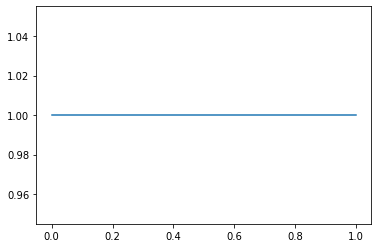

In [30]:
plt.plot(un_frozen,kr)